In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from itertools import combinations_with_replacement, permutations
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from qutip import *

In [2]:
sm1 = tensor( sigmam(), qeye(2) )
sm2 = tensor( qeye(2), sigmam() )

sx1 = tensor( sigmax(), qeye(2) )
sx2 = tensor( qeye(2), sigmax() )

sy1 = tensor( sigmay(), qeye(2) )
sy2 = tensor( qeye(2), sigmay() )

sz1 = tensor( sigmaz(), qeye(2) )
sz2 = tensor( qeye(2), sigmaz() )

h_H = (1./2.) * tensor( qeye(2) - (-sigmaz()+sigmax())/np.sqrt(2.), qeye(2) )
h_cnot = (1./4.) * tensor( qeye(2)+sigmaz(), qeye(2)-sigmax() )

evals, evecs = (1.3*sz1+sz2).eigenstates()
Psi_00 = evecs[0]
Psi_01 = evecs[1]
Psi_10 = evecs[2]
Psi_11 = evecs[3]

rho0 = Psi_00 * Psi_00.dag()


In [4]:
#Visualize states and gates in matrix shape
print(Psi_00, Psi_01, Psi_10, Psi_11)
print(sigmam())
print( np.around( (( (-1j*np.pi*h_cnot).expm() ).full()).real, decimals=2 ) )
print( np.around( (( (-1j*np.pi*h_H ).expm()*2**.5 ).full()).real, decimals=2 )  )

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]] Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]] Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]] Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[-1.  0.  1.  0.]
 [ 0. -1.  0.  1.]
 [ 1.  0.  1.  0.]
 [ 0.  1.  0.  1.]]


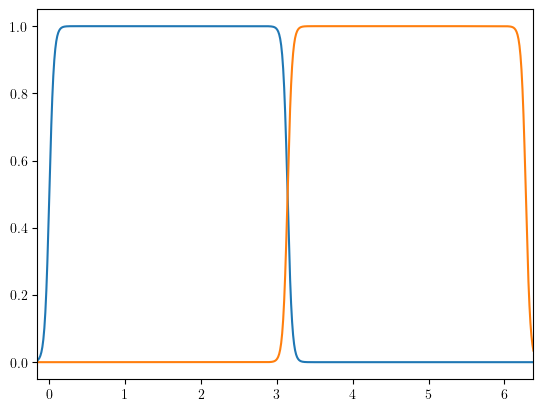

In [297]:
#Visualize the shape of the two pulses we are going to perform
f = lambda t, t0, t1, tau: 1 / (np.exp(-(t - t0) / tau) + 1) * (1 / (np.exp((t - t1) / tau) + 1))
plt.plot(times, f(times, 0, np.pi, 0.03))
plt.plot(times, f(times, np.pi, 2*np.pi, 0.03))

In [298]:
#Perform the time evolutioon of the physical system under the two subsequent pulses
om0 = 1
T = 1.
nT = 1./( np.exp(om0/T) - 1. )
gamma1 = .01
gamma2 = gamma1

t0 = 0
t1 = np.pi
t2 = np.pi*2
tau = .1

c_jumps = [ np.sqrt(gamma1*(1+nT))*sm1, np.sqrt(gamma1*(nT))*sm1.dag(), np.sqrt(gamma2*(1+nT))*sm2, np.sqrt(gamma2*(nT))*sm2.dag()  ]
#c_jumps = [ np.sqrt(gamma1)*sm1, np.sqrt(gamma2)*sm2 ]

H0 = sz1*0 + sz2*0

H1 = h_H
H2 = h_cnot
args =  {'t0': t0, 't1': t1, 't2':t2, 'tau': tau}

H = [H0, [ H1 , lambda t : 1 / (np.exp(-(t - args['t0']) / args['tau']) + 1) * (1 / (np.exp((t - args['t1']) / args['tau']) + 1)) ], [ H2 , lambda t : 1 / (np.exp(-(t - args['t1']) / args['tau']) + 1) * (1 / (np.exp((t - args['t2']) / args['tau']) + 1)) ] ]

times = np.linspace(-np.pi/20, t2+.1, 1000)

output = mesolve(H, rho0, times, c_jumps, e_ops=[], args=args)

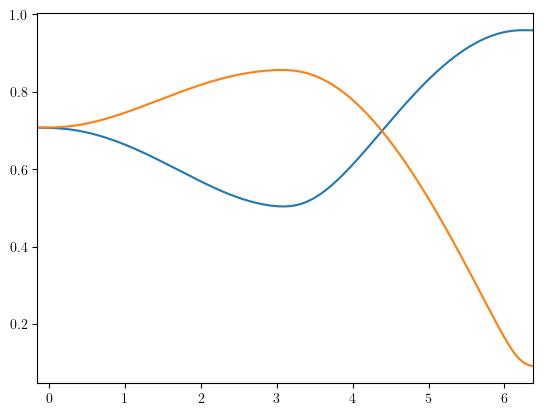

In [301]:
rhot = output.states
BellS = (Psi_00 + Psi_11)/np.sqrt(2.)
rho_bell = BellS * BellS.dag()


arr_fid = np.zeros( len(times) )
arr_dist = np.zeros( len(times) )
for nt, t in enumerate(times):
    arr_fid[nt] = np.abs( fidelity( rho_bell, rhot[nt] ) )
    arr_dist[nt] = np.abs( tracedist(rho_bell, rhot[nt]) )
    
plt.plot(times, arr_fid)
plt.plot(times, arr_dist)

In [305]:
#Repeat the previous algorithm for several values of the temperature T and see how the fidelity (or trace distant) of the output state is destroyed
om0 = 1

gamma1 = .03
gamma2 = gamma1

t0 = 0
t1 = np.pi
t2 = np.pi*2
tau = .1

#vT = np.linspace(.01, 10, 30)
vT = np.logspace(-2, 2, 30)
arr_fid_T = np.zeros(len(vT))
arr_dist_T = np.zeros(len(vT))

for indxT, T in enumerate(vT):
    nT = 1./( np.exp(om0/T) - 1. )
    c_jumps = [ np.sqrt(gamma1*(1+nT))*sm1, np.sqrt(gamma1*(nT))*sm1.dag(), np.sqrt(gamma2*(1+nT))*sm2, np.sqrt(gamma2*(nT))*sm2.dag()  ]

    H0 = sz1*0 + sz2*0

    H1 = h_H
    H2 = h_cnot
    args =  {'t0': t0, 't1': t1, 't2':t2, 'tau': tau}

    H = [H0, [ H1 , lambda t : 1 / (np.exp(-(t - args['t0']) / args['tau']) + 1) * (1 / (np.exp((t - args['t1']) / args['tau']) + 1)) ], [ H2 , lambda t : 1 / (np.exp(-(t - args['t1']) / args['tau']) + 1) * (1 / (np.exp((t - args['t2']) / args['tau']) + 1)) ] ]

    times = np.linspace(-np.pi/20, t2+.1, 1000)

    output = mesolve(H, rho0, times, c_jumps, e_ops=[], args=args)
    rhot = output.states
    rho_out = rhot[len(times)-1]
    arr_fid_T[indxT] = np.abs( fidelity( rho_bell, rho_out ) )
    arr_dist_T[indxT] = np.abs( 1-tracedist( rho_bell, rho_out ) )
    

(0.0, 1.0)

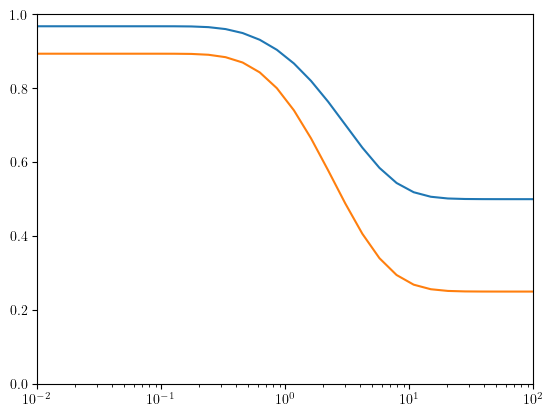

In [306]:
plt.plot(vT, arr_fid_T)
plt.plot(vT, arr_dist_T)
plt.xscale('log')
plt.ylim(0,1)

In [208]:
#TEST GATES
om0 = 1
T = .01
nT = 1./( np.exp(om0/T) - 1. )
gamma1 = .2
gamma2 = .2

t0 = 0
t1 = np.pi
tau = .2

#c_jumps = [ np.sqrt(gamma1*(1+nT))*sm1, np.sqrt(gamma1*(nT))*sm1.dag(), np.sqrt(gamma2*(1+nT))*sm2, np.sqrt(gamma2*(nT))*sm2.dag()  ]
c_jumps = [ np.sqrt(gamma1)*sm1, np.sqrt(gamma2)*sm2 ]

H0 = sz1*0 + sz2*0

rho0 = Psi_01 * Psi_01.dag()

Hg = h_cnot
args =  {'t0': t0, 't1': t1, 'tau': tau}

H = [H0, [ Hg , lambda t : 1 / (np.exp(-(t - args['t0']) / args['tau']) + 1) * (1 / (np.exp((t - args['t1']) / args['tau']) + 1)) ] ]

times = np.linspace(-np.pi/20, t1+.1, 1000)

output = mesolve(H, rho0, times, c_jumps, e_ops=[], args=args)

0.0
0.8238527990229974
0.8238527990229974


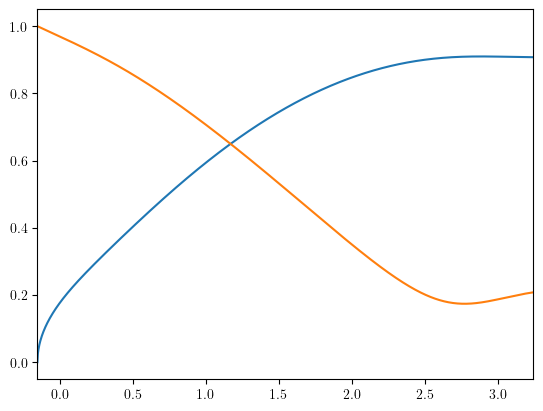

In [209]:
rhot = output.states

#TGstate = (Psi_10 + Psi_00)/2**.5
TGstate = Psi_00
rho_TG = TGstate * TGstate.dag()

print( expect(rhot[len(times)-1], Psi_11) ) 
print( expect(rhot[len(times)-1], Psi_00) ) 
print( expect(rhot[len(times)-1], TGstate) ) 


arr_fid = np.zeros( len(times) )
arr_dist = np.zeros( len(times) )
for nt, t in enumerate(times):
    arr_fid[nt] = np.abs( fidelity( rho_TG, rhot[nt] ) )
    arr_dist[nt] = np.abs( tracedist(rho_TG, rhot[nt]) )
    
plt.plot(times, arr_fid)
plt.plot(times, arr_dist)

In [289]:

print( (-1j*np.pi*h_cnot).expm() )

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.57335903e-17 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.41330427e-17 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [226]:
h_H = (1./2.) * tensor( qeye(2) - (-sigmaz()+sigmax())/np.sqrt(2.), qeye(2) )
print( (-1j*np.pi*h_H ).expm()*2**.5 )

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.  0.  1.  0.]
 [ 0. -1.  0.  1.]
 [ 1.  0.  1.  0.]
 [ 0.  1.  0.  1.]]
